# Tutorial for AutoSARIMA Forecasting Model

This notebook provides an advanced example on how to use the Auto Sarima forecasting model.

AutoSARIMA runs in 4 settings:
1. Full AutoSARIMA with approximation 
2. Full AutoSARIMA without approximation
3. Partial AutoSARIMA (Predefined AR, MA, Seasonal AR, Seasonal MA hyper-parameters)
4. Autosarima without enforcing stationarity and invertibility (this is the default setting) 

Example codes are provided for both cases below.

## Prepare dataset

plotly not installed, so plotly visualizations will not work.
INFO:ts_datasets.forecast.m4:M4 Hourly dataset cannot be found from /Users/chenghao.liu/Documents/research-project/Merlion_backup/public_merlion/Merlion/data/M4.
M4 Hourly dataset will be downloaded from https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/{}.csv.

INFO:ts_datasets.forecast.m4:Downloading https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/M4-info.csv
INFO:ts_datasets.forecast.m4:Downloading https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/Train/Hourly-train.csv
INFO:ts_datasets.forecast.m4:Downloading https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/Test/Hourly-test.csv
100%|██████████| 414/414 [00:05<00:00, 72.11it/s] 


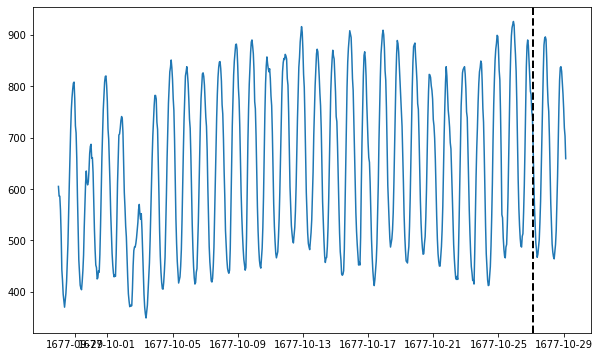

700 points in train split, 48 points in test split.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import logging

from merlion.utils.time_series import TimeSeries
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.automl.autosarima import AutoSarima, AutoSarimaConfig
from merlion.models.automl.seasonality_mixin import SeasonalityLayer
from merlion.models.forecast.sarima import Sarima

from ts_datasets.forecast import M4

logging.basicConfig(level=logging.DEBUG)

time_series, metadata = M4("Hourly")[0]
train_data = TimeSeries.from_pd(time_series[metadata.trainval])
test_data = TimeSeries.from_pd(time_series[~metadata.trainval])

# Visualize the time series and draw a dotted line to indicate the train/test split
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time_series)
ax.axvline(metadata[metadata.trainval].index[-1], ls="--", lw="2", c="k")
plt.show()

# Print the length of training data and test data
print(f"{len(train_data)} points in train split, "
      f"{len(test_data)} points in test split.")

## Train a full AutoSarima model with approximation (suggested)

In [2]:
# Specify the configuration of AutoSarima with approximation
config1 = AutoSarimaConfig(max_forecast_steps=len(train_data), order=("auto", "auto", "auto"),
                           seasonal_order=("auto", "auto", "auto", "auto"), approximation=True, maxiter=5)
model1  = SeasonalityLayer(model = AutoSarima(model = Sarima(config1)))

# Model training
train_pred, train_err = model1.train(
    train_data, train_config={"enforce_stationarity": True,"enforce_invertibility": True})

# Model forecasting
forecast1, stderr1 = model1.forecast(len(test_data))

# Model evaluation
smape1 = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast1)
print(f"Full AutoSarima with approximation sMAPE is {smape1:.4f}")

INFO:merlion.models.forecast.base:Automatically detect the periodicity is 24
INFO:merlion.models.forecast.sarima:Seasonal difference order is 1
INFO:merlion.models.forecast.sarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Seasonal difference order is 1
INFO:merlion.models.automl.autosarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Seasonal difference order is 1
INFO:merlion.models.automl.autosarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Fitting models using approximations(approx_iter is 1) to speed things up
INFO:merlion.models.automl.autosarima:Best model:  SARIMA(2,0,2)(0,1,1)[24] without constant


Full AutoSarima with approximation sMAPE is 3.4491


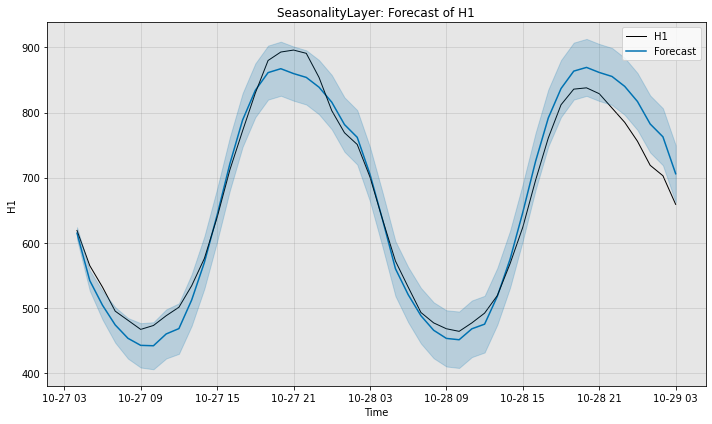

In [3]:
# Visualize the groud truth, actual forecast and confident interval 
fig, ax = model1.plot_forecast(time_series=test_data,
                               plot_forecast_uncertainty=True)
plt.show()

## Train a full AutoSarima model without approximation

In [5]:
# Specify the configuration of full AutoSarima without approximation
config2 = AutoSarimaConfig(max_forecast_steps=len(train_data), order=("auto", "auto", "auto"),
                           seasonal_order=("auto", "auto", "auto", "auto"), approximation=False, maxiter=5)
model2  = SeasonalityLayer(model = AutoSarima(model = Sarima(config2)))

# Model training
train_pred, train_err = model2.train(
    train_data, train_config={"enforce_stationarity": True,"enforce_invertibility": True})

# Model forecasting
forecast2, stderr2 = model2.forecast(len(test_data))

# Model evaluation
smape2 = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast2)
print(f"Full AutoSarima without approximation sMAPE is {smape2:.4f}")

INFO:merlion.models.forecast.base:Automatically detect the periodicity is 24
INFO:merlion.models.forecast.sarima:Seasonal difference order is 1
INFO:merlion.models.forecast.sarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Seasonal difference order is 1
INFO:merlion.models.automl.autosarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Seasonal difference order is 1
INFO:merlion.models.automl.autosarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Best model:  SARIMA(2,0,3)(1,1,1)[24] without constant


Full AutoSarima without approximation sMAPE is 3.6991


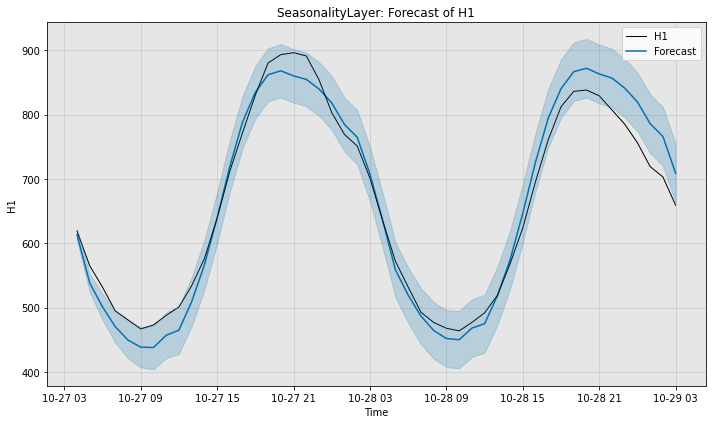

In [6]:
# Visualize the groud truth, actual forecast and confident interval 
fig, ax = model2.plot_forecast(time_series=test_data,
                               plot_forecast_uncertainty=True)
plt.show()

## Train a partial autosarima model

Here, the user has pre-defined the AR, MA, Seasonal AR, and Seasonal MA hyper-parameters.

In [7]:
# Specify the configuration of partial AutoSarima 
config3 = AutoSarimaConfig(max_forecast_steps=len(train_data), order=(15, "auto", 5),
                           seasonal_order=(2, "auto", 1, "auto"), maxiter=5)
model3  = SeasonalityLayer(model = AutoSarima(model = Sarima(config3)))

# Model training
train_pred, train_err = model3.train(
    train_data, train_config={"enforce_stationarity": True,"enforce_invertibility": True})

# Model forecasting
forecast3, stderr3 = model3.forecast(len(test_data))

# Model evaluation
smape3 = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast3)
print(f"Partial AutoSarima without approximation sMAPE is {smape3:.4f}")

INFO:merlion.models.forecast.base:Automatically detect the periodicity is 24
INFO:merlion.models.forecast.sarima:Seasonal difference order is 1
INFO:merlion.models.forecast.sarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Seasonal difference order is 1
INFO:merlion.models.automl.autosarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Seasonal difference order is 1
INFO:merlion.models.automl.autosarima:Difference order is 0


Partial AutoSarima without approximation sMAPE is 3.5288


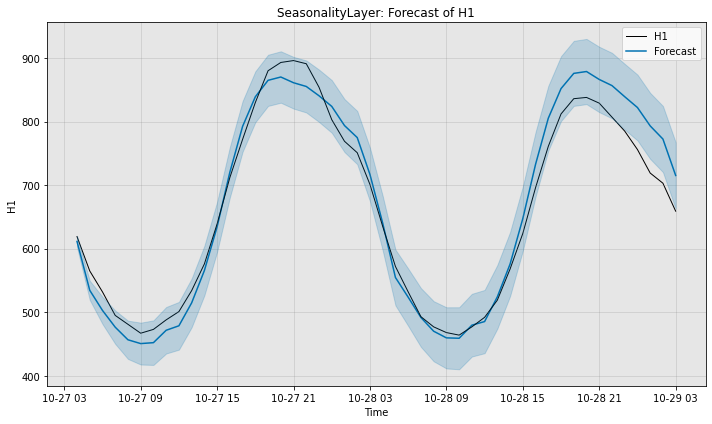

In [8]:
# Visualize the groud truth, actual forecast and confident interval 
fig, ax = model3.plot_forecast(time_series=test_data,
                               plot_forecast_uncertainty=True)
plt.show()

## Train without enforcing stationarity and invertibility (default)

In [9]:
# Specify the configuration of AutoSarima without enforcing stationarity and invertibility
config4 = AutoSarimaConfig(max_forecast_steps=len(train_data), order=("auto", "auto", "auto"),
                           seasonal_order=("auto", "auto", "auto", "auto"), maxiter=5)
model4  = SeasonalityLayer(model = AutoSarima(model = Sarima(config4)))

# Model training
train_pred, train_err = model4.train(
    train_data, train_config={"enforce_stationarity": False,"enforce_invertibility": False})

# Model forecasting
forecast4, stderr4 = model4.forecast(len(test_data))

# Model evaluation
smape4 = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast4)
print(f"AutoSarima without enforcing stationarity and invertibility sMAPE is {smape4:.4f}")

INFO:merlion.models.forecast.base:Automatically detect the periodicity is 24
INFO:merlion.models.forecast.sarima:Seasonal difference order is 1
INFO:merlion.models.forecast.sarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Seasonal difference order is 1
INFO:merlion.models.automl.autosarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Seasonal difference order is 1
INFO:merlion.models.automl.autosarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Fitting models using approximations(approx_iter is 1) to speed things up
INFO:merlion.models.automl.autosarima:Best model:  SARIMA(1,0,5)(0,1,2)[24] without constant


AutoSarima without enforcing stationarity and invertibility sMAPE is 3.4972
